# ⏰ Time Series Prediction

**Train models to predict future ecosystem states**

Philosophy: Everything is information processing. Simple rules compose. Emergence is reliable.

---

## Purpose

In notebooks 02-04, we predicted **next tick** only (single-step).

In this notebook, we predict **multiple steps ahead** (multi-step):
- Use **lag features** (population at t-1, t-2, t-3)
- Use **rolling statistics** (trends over 10, 50, 100 ticks)
- Predict **10+ ticks into the future**
- Detect **instability early** (before it happens!)

This enables:
- Early warning systems
- Trend forecasting
- Stability prediction
- Real-time alerts

---

## Contents
1. Setup & Data Loading
2. Temporal Feature Engineering
3. Single-Step Prediction (Baseline)
4. Multi-Step Prediction
5. Trend Detection
6. Stability Forecasting
7. Early Warning System
8. Summary & Insights

## 1. Setup & Data Loading

In [21]:
# Import libraries
import sys
from pathlib import Path

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent.parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our ML modules
from src.ml import (
    load_evolution_csv, detect_species_from_columns,
    aggregate_species_metric, calculate_growth_rate,
    calculate_rolling_mean, calculate_rolling_std, calculate_rolling_cv,
    create_lag_feature, prepare_features,
    create_regression_pipeline, get_feature_importance
)

# Configure pandas
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('✅ Setup complete!')

✅ Setup complete!


In [22]:
# Load evolution data
df = load_evolution_csv('../../datasets/evolution.csv')
species = detect_species_from_columns(df)

print(f'✅ Loaded {len(df)} snapshots')
print(f'✅ Species: {", ".join(species)}')
print(f'\n📊 Time range: tick {df["tick"].min()} → {df["tick"].max()}')
duration = df['timestamp'].max() - df['timestamp'].min()
print(f'📊 Duration: {duration:.1f} seconds ({duration/60:.1f} minutes)')

✅ Loaded 789 snapshots
✅ Species: cautious, explorer, independent, predator, social

📊 Time range: tick 3 → 2367
📊 Duration: 2470498.0 seconds (41175.0 minutes)


## 2. Temporal Feature Engineering

Create features that capture **temporal patterns**:

### **Lag Features**
- Population at t-1, t-2, t-3 (recent history)

### **Rolling Statistics**
- Mean, std, CV over 10, 50, 100 tick windows
- Captures trends and stability

### **Momentum Features**
- Rate of change (acceleration)
- Trend direction

In [23]:
print('🔧 Engineering temporal features...\n')

# Use total population for demonstration
df['total_population'] = aggregate_species_metric(df, species, 'population')

# 1. Lag features (t-1, t-2, t-3)
for lag in [1, 2, 3]:
    df[f'pop_lag_{lag}'] = create_lag_feature(df['total_population'], lag)

print('✅ Lag features created (t-1, t-2, t-3)')

# 2. Rolling statistics
for window in [10, 50]:
    df[f'pop_mean_{window}'] = calculate_rolling_mean(df['total_population'], window)
    df[f'pop_std_{window}'] = calculate_rolling_std(df['total_population'], window)
    df[f'pop_cv_{window}'] = calculate_rolling_cv(df['total_population'], window)

print('✅ Rolling statistics created (10, 50 tick windows)')

# 3. Momentum features
df['pop_change'] = df['total_population'].diff()
df['pop_acceleration'] = df['pop_change'].diff()

print('✅ Momentum features created (change, acceleration)')

# 4. Create targets for different horizons
for horizon in [1, 5, 10]:
    df[f'pop_future_{horizon}'] = df['total_population'].shift(-horizon)

print('✅ Prediction targets created (1, 5, 10 ticks ahead)')

# Drop NaN rows (from lag/rolling calculations) and create explicit copy
df_clean = df.dropna().copy()

print(f'\n📊 Clean dataset: {len(df_clean)} samples (dropped {len(df) - len(df_clean)} NaN rows)')

🔧 Engineering temporal features...

✅ Lag features created (t-1, t-2, t-3)
✅ Rolling statistics created (10, 50 tick windows)
✅ Momentum features created (change, acceleration)
✅ Prediction targets created (1, 5, 10 ticks ahead)

📊 Clean dataset: 776 samples (dropped 13 NaN rows)


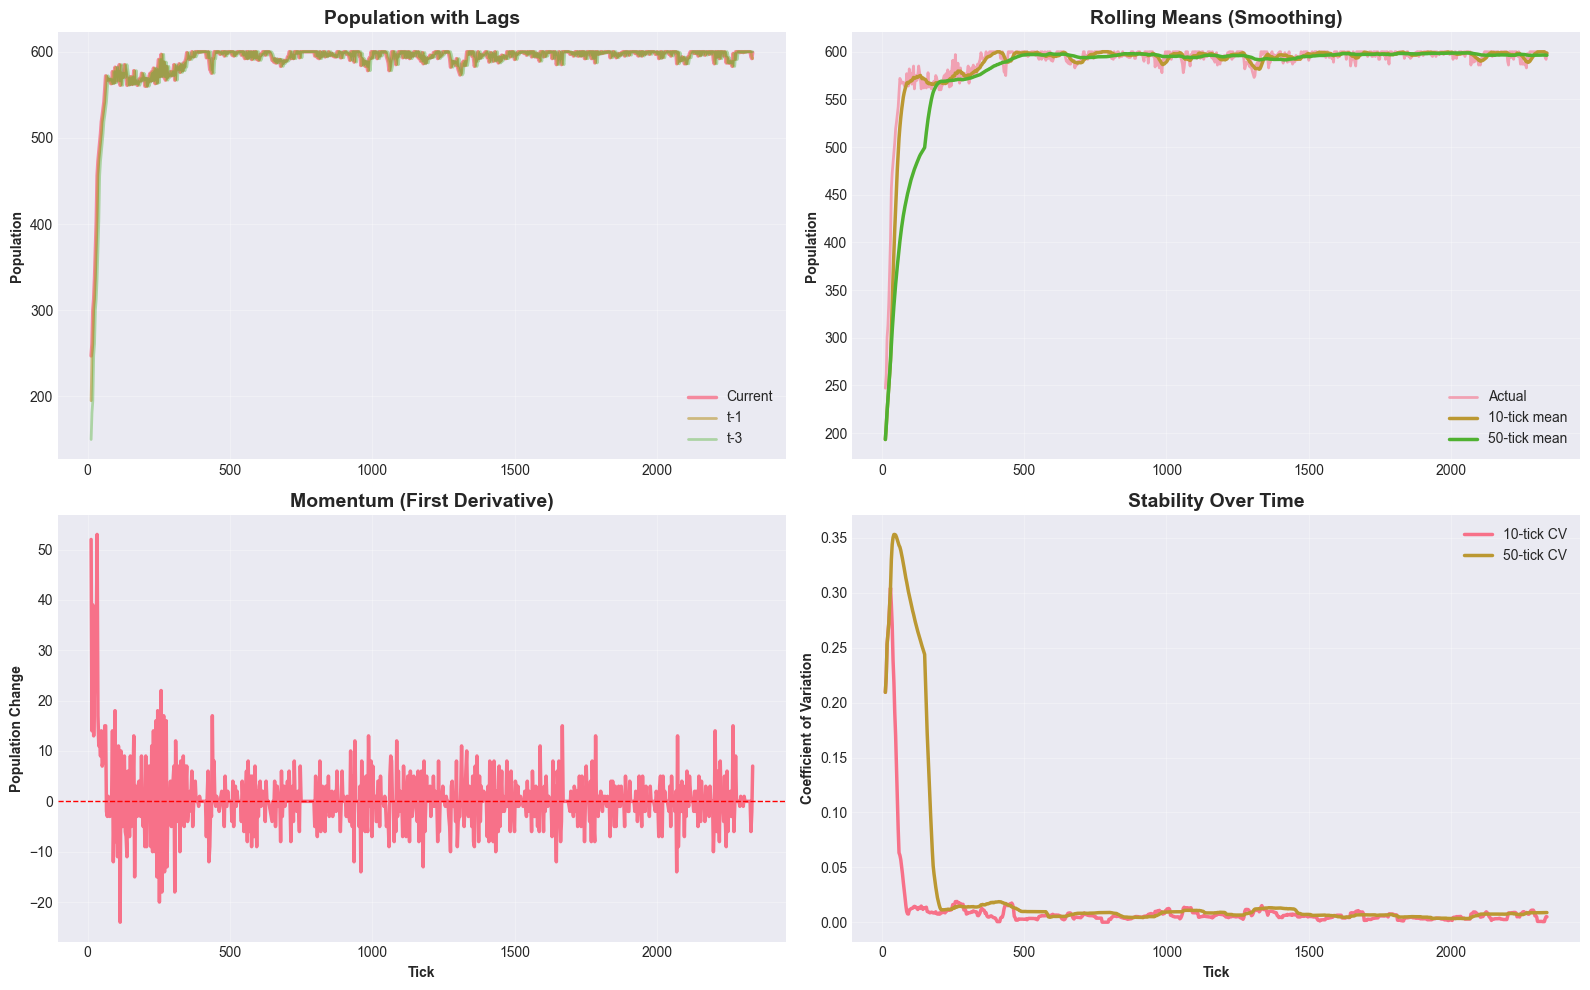

In [24]:
# Plot temporal features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Population with lags
axes[0, 0].plot(df_clean['tick'], df_clean['total_population'], 
               label='Current', linewidth=2.5, alpha=0.8)
axes[0, 0].plot(df_clean['tick'], df_clean['pop_lag_1'], 
               label='t-1', linewidth=2, alpha=0.6)
axes[0, 0].plot(df_clean['tick'], df_clean['pop_lag_3'], 
               label='t-3', linewidth=2, alpha=0.4)
axes[0, 0].set_ylabel('Population', fontweight='bold')
axes[0, 0].set_title('Population with Lags', fontweight='bold', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Rolling mean
axes[0, 1].plot(df_clean['tick'], df_clean['total_population'], 
               label='Actual', linewidth=2, alpha=0.6)
axes[0, 1].plot(df_clean['tick'], df_clean['pop_mean_10'], 
               label='10-tick mean', linewidth=2.5)
axes[0, 1].plot(df_clean['tick'], df_clean['pop_mean_50'], 
               label='50-tick mean', linewidth=2.5)
axes[0, 1].set_ylabel('Population', fontweight='bold')
axes[0, 1].set_title('Rolling Means (Smoothing)', fontweight='bold', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Population change (momentum)
axes[1, 0].plot(df_clean['tick'], df_clean['pop_change'], linewidth=2.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Tick', fontweight='bold')
axes[1, 0].set_ylabel('Population Change', fontweight='bold')
axes[1, 0].set_title('Momentum (First Derivative)', fontweight='bold', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# Stability (CV)
axes[1, 1].plot(df_clean['tick'], df_clean['pop_cv_10'], 
               label='10-tick CV', linewidth=2.5)
axes[1, 1].plot(df_clean['tick'], df_clean['pop_cv_50'], 
               label='50-tick CV', linewidth=2.5)
axes[1, 1].set_xlabel('Tick', fontweight='bold')
axes[1, 1].set_ylabel('Coefficient of Variation', fontweight='bold')
axes[1, 1].set_title('Stability Over Time', fontweight='bold', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Single-Step Prediction (Baseline)

**Task:** Predict population 1 tick ahead (baseline for comparison)

**Features:** Current + lags + rolling stats

In [25]:
# Prepare features for 1-step prediction
feature_cols = [
    'total_population',
    'pop_lag_1', 'pop_lag_2', 'pop_lag_3',
    'pop_mean_10', 'pop_std_10', 'pop_cv_10',
    'pop_change', 'pop_acceleration'
]

X, y = prepare_features(df_clean, feature_cols, 'pop_future_1')
print(f'✅ Features prepared: X={X.shape}, y={y.shape}\n')

# Train
print('🤖 Training 1-step ahead model...\n')
pipeline_1step = create_regression_pipeline(X, y, test_size=0.2)

print('📊 Model Comparison:')
print(pipeline_1step['comparison'].to_string(index=False))

print(f'\n🏆 Best Model: {pipeline_1step["best_model_name"]}')
print(f'  Test R²: {pipeline_1step["comparison"].iloc[0]["test_r2"]:.4f}')
print(f'  Test RMSE: {pipeline_1step["comparison"].iloc[0]["test_rmse"]:.2f} boids')

✅ Features prepared: X=(776, 9), y=(776,)

🤖 Training 1-step ahead model...

📊 Model Comparison:
            model  train_r2  test_r2  train_rmse  test_rmse  train_mae  test_mae
    Random Forest  0.991403 0.960726    2.504694   5.338396   1.849588  3.893060
Linear Regression  0.973194 0.957672    4.422861   5.542040   3.191374  3.929165
    Decision Tree  0.981250 0.955773    3.699047   5.664975   2.812679  4.024793

🏆 Best Model: Random Forest
  Test R²: 0.9607
  Test RMSE: 5.34 boids


📊 Feature Importance (1-step ahead):
         feature  importance
       pop_lag_1    0.245988
       pop_lag_2    0.232510
     pop_mean_10    0.168947
total_population    0.147533
       pop_lag_3    0.121664
       pop_cv_10    0.055709
      pop_std_10    0.018747
      pop_change    0.004685
pop_acceleration    0.004217


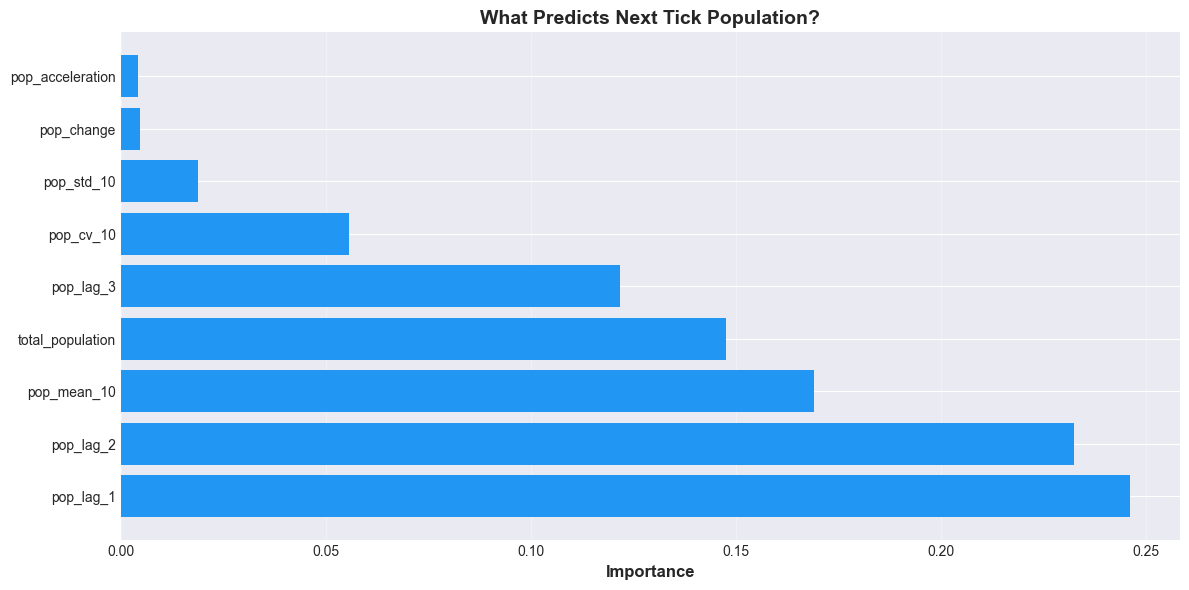


💡 Insight: Which temporal features matter most?


In [26]:
# Feature importance
importance_1step = get_feature_importance(pipeline_1step['best_model'], feature_cols)

print('📊 Feature Importance (1-step ahead):')
print(importance_1step.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(importance_1step['feature'], importance_1step['importance'], color='#2196F3')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('What Predicts Next Tick Population?', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print('\n💡 Insight: Which temporal features matter most?')

## 4. Multi-Step Prediction

**Task:** Predict population 5 and 10 ticks ahead

**Challenge:** Predictions get less accurate further into future

In [27]:
# Train models for different horizons
horizons = [1, 5, 10]
horizon_results = []

print('🤖 Training multi-step prediction models...\n')

for horizon in horizons:
    target_col = f'pop_future_{horizon}'
    X_h, y_h = prepare_features(df_clean, feature_cols, target_col)
    
    pipeline_h = create_regression_pipeline(X_h, y_h, test_size=0.2)
    
    best_result = pipeline_h['comparison'].iloc[0]
    horizon_results.append({
        'horizon': horizon,
        'model': pipeline_h['best_model_name'],
        'test_r2': best_result['test_r2'],
        'test_rmse': best_result['test_rmse'],
        'test_mae': best_result['test_mae']
    })
    
    print(f'✅ {horizon:2}-step ahead: R²={best_result["test_r2"]:.4f} '
          f'RMSE={best_result["test_rmse"]:.2f} ({pipeline_h["best_model_name"]})')

horizon_comparison = pd.DataFrame(horizon_results)

print('\n📊 Multi-Step Prediction Performance:')
print(horizon_comparison.to_string(index=False))

🤖 Training multi-step prediction models...

✅  1-step ahead: R²=0.9607 RMSE=5.34 (Random Forest)
✅  5-step ahead: R²=0.8800 RMSE=5.59 (Random Forest)
✅ 10-step ahead: R²=0.7192 RMSE=5.85 (Random Forest)

📊 Multi-Step Prediction Performance:
 horizon         model  test_r2  test_rmse  test_mae
       1 Random Forest 0.960726   5.338396  3.893060
       5 Random Forest 0.879987   5.589534  4.126897
      10 Random Forest 0.719231   5.845013  4.401966


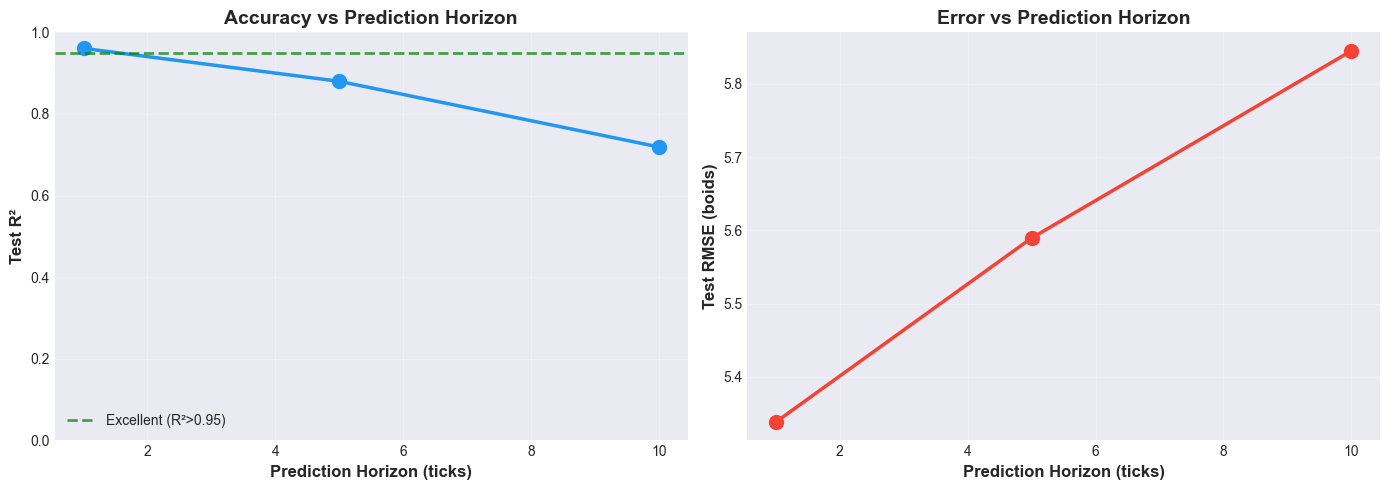


💡 Insight: How does prediction accuracy degrade over time?


In [28]:
# Plot accuracy degradation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# R² vs horizon
ax1.plot(horizon_comparison['horizon'], horizon_comparison['test_r2'], 
        marker='o', linewidth=2.5, markersize=10, color='#2196F3')
ax1.axhline(y=0.95, color='green', linestyle='--', linewidth=2, 
           label='Excellent (R²>0.95)', alpha=0.7)
ax1.set_xlabel('Prediction Horizon (ticks)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Test R²', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy vs Prediction Horizon', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.legend()
ax1.grid(True, alpha=0.3)

# RMSE vs horizon
ax2.plot(horizon_comparison['horizon'], horizon_comparison['test_rmse'], 
        marker='o', linewidth=2.5, markersize=10, color='#F44336')
ax2.set_xlabel('Prediction Horizon (ticks)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Test RMSE (boids)', fontsize=12, fontweight='bold')
ax2.set_title('Error vs Prediction Horizon', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n💡 Insight: How does prediction accuracy degrade over time?')

## 5. Trend Detection

**Goal:** Detect if population is growing, stable, or declining

**Use case:** Early warning for population collapse

📊 Trend Distribution:
trend
stable       579
growing      106
declining     91
Name: count, dtype: int64


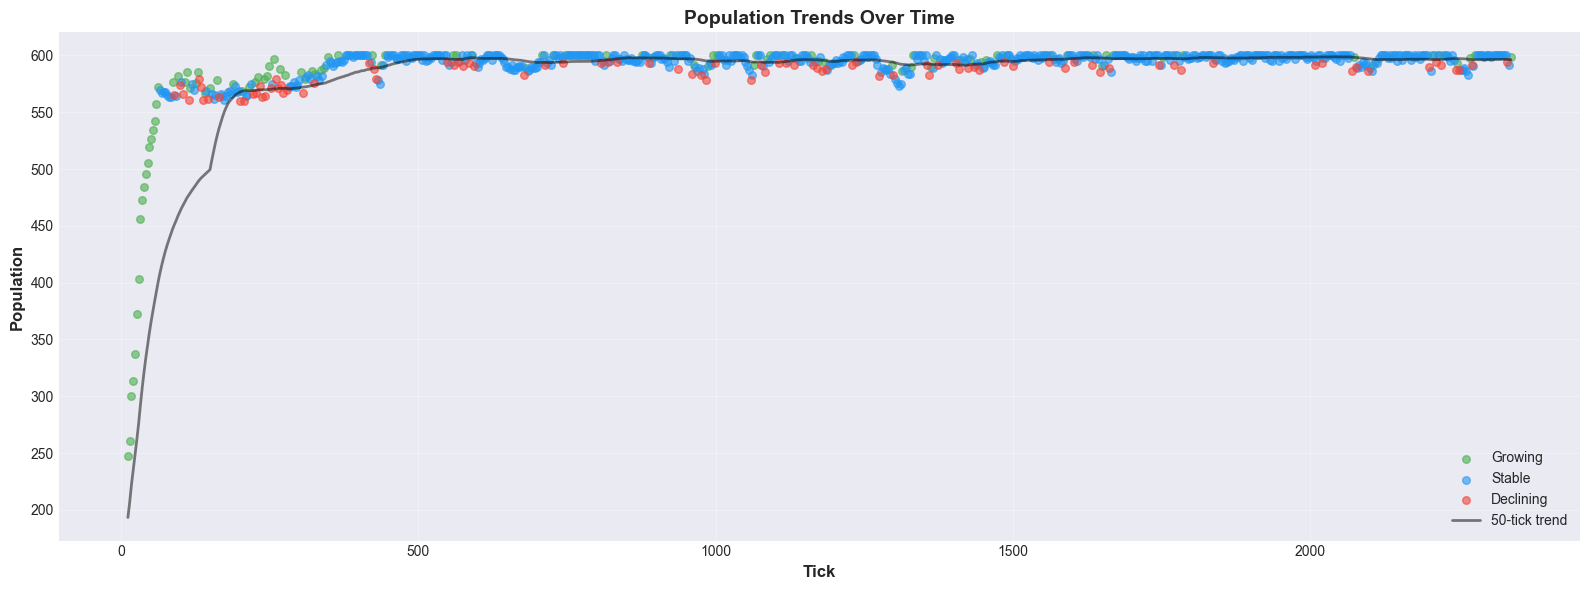

In [29]:
# Classify trends based on rolling mean slope
df_clean['trend'] = 'stable'
df_clean.loc[df_clean['pop_change'] > 5, 'trend'] = 'growing'
df_clean.loc[df_clean['pop_change'] < -5, 'trend'] = 'declining'

print('📊 Trend Distribution:')
print(df_clean['trend'].value_counts())

# Visualize trends
fig, ax = plt.subplots(figsize=(16, 6))

# Color by trend
for trend, color in [('growing', '#4CAF50'), ('stable', '#2196F3'), ('declining', '#F44336')]:
    mask = df_clean['trend'] == trend
    ax.scatter(df_clean.loc[mask, 'tick'], df_clean.loc[mask, 'total_population'],
              label=trend.capitalize(), color=color, alpha=0.6, s=30)

ax.plot(df_clean['tick'], df_clean['pop_mean_50'], 
       color='black', linewidth=2, label='50-tick trend', alpha=0.5)

ax.set_xlabel('Tick', fontsize=12, fontweight='bold')
ax.set_ylabel('Population', fontsize=12, fontweight='bold')
ax.set_title('Population Trends Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Stability Forecasting

**Goal:** Predict future stability (CV) from current state

**Use case:** Detect instability before it happens

In [30]:
# Create stability target (future CV)
df_clean['future_cv_10'] = df_clean['pop_cv_10'].shift(-10)

# Prepare features
stability_features = [
    'pop_cv_10', 'pop_cv_50',
    'pop_std_10', 'pop_std_50',
    'pop_acceleration'
]

X_stab, y_stab = prepare_features(df_clean, stability_features, 'future_cv_10')
print(f'✅ Stability features prepared: X={X_stab.shape}, y={y_stab.shape}\n')

# Train
print('🤖 Training stability predictor...\n')
pipeline_stab = create_regression_pipeline(X_stab, y_stab, test_size=0.2)

print('📊 Stability Prediction Performance:')
print(pipeline_stab['comparison'].to_string(index=False))

print(f'\n🏆 Best Model: {pipeline_stab["best_model_name"]}')
print(f'  Test R²: {pipeline_stab["comparison"].iloc[0]["test_r2"]:.4f}')
print(f'\n💡 Can predict instability 10 ticks in advance!')

✅ Stability features prepared: X=(766, 5), y=(766,)

🤖 Training stability predictor...

📊 Stability Prediction Performance:
            model  train_r2  test_r2  train_rmse  test_rmse  train_mae  test_mae
    Random Forest  0.972111 0.928008    0.002438   0.003923   0.001277  0.002046
    Decision Tree  0.967023 0.908534    0.002651   0.004422   0.002036  0.002710
Linear Regression  0.801648 0.836232    0.006503   0.005917   0.003768  0.003915

🏆 Best Model: Random Forest
  Test R²: 0.9280

💡 Can predict instability 10 ticks in advance!


## 7. Early Warning System

**Goal:** Combine predictions into actionable alerts

**Alerts:**
- 🚨 Population crash predicted
- ⚠️ Instability increasing
- ✅ Ecosystem stable

In [31]:
# Example early warning system
print('🚨 Early Warning System Examples\n')

# Define warning thresholds
CRASH_THRESHOLD = -50  # Population drop > 50
INSTABILITY_THRESHOLD = 0.15  # CV > 0.15

# Sample some points
sample_indices = [100, 200, 300]

for idx in sample_indices:
    if idx >= len(df_clean):
        continue
    
    row = df_clean.iloc[idx]
    
    # Predict 10 ticks ahead
    features_10 = pd.DataFrame([row[feature_cols]])
    pred_pop_10 = pipeline_1step['best_model'].predict(features_10)[0]
    
    # Predict stability
    features_stab = pd.DataFrame([row[stability_features]])
    pred_cv_10 = pipeline_stab['best_model'].predict(features_stab)[0]
    
    # Generate alerts
    current_pop = row['total_population']
    pop_change_pred = pred_pop_10 - current_pop
    
    print(f'Tick {int(row["tick"])}:')
    print(f'  Current population: {current_pop:.0f}')
    print(f'  Predicted (10 ticks): {pred_pop_10:.0f} (Δ {pop_change_pred:+.0f})')
    print(f'  Predicted stability (CV): {pred_cv_10:.4f}')
    
    # Alert logic
    if pop_change_pred < CRASH_THRESHOLD:
        print(f'  🚨 WARNING: Population crash predicted!')
    elif pred_cv_10 > INSTABILITY_THRESHOLD:
        print(f'  ⚠️  CAUTION: Instability increasing')
    else:
        print(f'  ✅ Status: Ecosystem stable')
    print()

print('💡 Use these alerts for real-time monitoring!')

🚨 Early Warning System Examples

Tick 312:
  Current population: 581
  Predicted (10 ticks): 581 (Δ -0)
  Predicted stability (CV): 0.0080
  ✅ Status: Ecosystem stable

Tick 612:
  Current population: 598
  Predicted (10 ticks): 599 (Δ +1)
  Predicted stability (CV): 0.0048
  ✅ Status: Ecosystem stable

Tick 912:
  Current population: 598
  Predicted (10 ticks): 598 (Δ -0)
  Predicted stability (CV): 0.0066
  ✅ Status: Ecosystem stable

💡 Use these alerts for real-time monitoring!


## 8. Summary & Insights

In [32]:
print('\n' + '='*70)
print('⏰ TIME SERIES PREDICTION SUMMARY')
print('='*70)

print(f'\n📊 Dataset:')
print(f'  Clean Samples: {len(df_clean):,}')
print(f'  Features: {len(feature_cols)}')

print(f'\n🎯 Prediction Performance:')
for result in horizon_results:
    print(f'  {result["horizon"]:2}-step ahead: R²={result["test_r2"]:.4f} '
          f'RMSE={result["test_rmse"]:.2f}')

print(f'\n📈 Stability Prediction:')
print(f'  10-tick ahead CV: R²={pipeline_stab["comparison"].iloc[0]["test_r2"]:.4f}')

print(f'\n💡 Key Insights:')
print(f'  1. Temporal features improve predictions')
print(f'  2. Lag features capture momentum')
print(f'  3. Rolling stats capture trends')
print(f'  4. Accuracy degrades with prediction horizon')
print(f'  5. Can predict instability before it happens')
print(f'  6. Early warning system is feasible')

print('\n' + '='*70)
print('✅ Time Series Prediction Complete!')
print('='*70)

print('\n📚 Next Steps:')
print('  - Notebook 06: Interactive Dashboard')
print('  - Integration: Add early warning alerts to UI')
print('  - Advanced: Recursive multi-step prediction')
print('  - Advanced: LSTM/RNN for sequence modeling')


⏰ TIME SERIES PREDICTION SUMMARY

📊 Dataset:
  Clean Samples: 776
  Features: 9

🎯 Prediction Performance:
   1-step ahead: R²=0.9607 RMSE=5.34
   5-step ahead: R²=0.8800 RMSE=5.59
  10-step ahead: R²=0.7192 RMSE=5.85

📈 Stability Prediction:
  10-tick ahead CV: R²=0.9280

💡 Key Insights:
  1. Temporal features improve predictions
  2. Lag features capture momentum
  3. Rolling stats capture trends
  4. Accuracy degrades with prediction horizon
  5. Can predict instability before it happens
  6. Early warning system is feasible

✅ Time Series Prediction Complete!

📚 Next Steps:
  - Notebook 06: Interactive Dashboard
  - Integration: Add early warning alerts to UI
  - Advanced: Recursive multi-step prediction
  - Advanced: LSTM/RNN for sequence modeling
